# Project WSL: Why So Long?

## __Table of Contents for :__
* [Section 1: Problem Introduction and Datasets](#part1)
* [Section 2: Data Pre-processing](#part2)
    * [Pre-processing Steps](#part21)
    * [Map Matching](#part22)
* [Section 3: Clean Data, now the analysis](#part3)
    * [Shortlisting of trips](#part31)
    * [Aspect 1 of delay: Speed bottlenecks](#part32)
    * [Aspect 2 of delay: Non-optimal routing](#part33)

***
<a id='part1'></a>
# Section 1: Problem Introduction and Datasets

In a fast-paced society, we are especially concerned when things do not go as efficiently as expected. Now, equipped with some data analytic tools, we want to progress from complaining each time our Grab ride or food order arrives late, to actually understanding the **why** and **how** can we do better.

<p> This notebook addresses 3 key sections, (i) data pre-processing, where we have read the paper to understand the dataset better and perform relevant data pre-processing steps, (ii) do some detective work and find out what could possibly lead to delays, (iii) some innovative ideations we have come up with to address the reasons found in Part (ii). But first, some Python dependencies. </p>

### Python dependencies

In [2]:
from preprocess import *
import pandas as pd 
import geopandas as gpd
import osmnx as ox
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sys
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import datetime, timedelta, timezone
import numpy as np
from shapely.ops import nearest_points
from shapely.geometry import LineString

from ipyleaflet import (Map, GeoData, basemaps, WidgetControl, GeoJSON,
                        LayersControl, Icon, Marker,basemap_to_tiles, Choropleth,
                        MarkerCluster, Heatmap,SearchControl, 
                        FullScreenControl)
from ipywidgets import Text, HTML

%load_ext autoreload
%autoreload 2

### For us to track memory usage:

In [3]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('basemaps', 1192),
 ('BeautifulSoup', 1064),
 ('Choropleth', 1064),
 ('FullScreenControl', 1064),
 ('GeoData', 1064),
 ('GeoJSON', 1064),
 ('HTML', 1064),
 ('Heatmap', 1064),
 ('Icon', 1064),
 ('LayersControl', 1064),
 ('LineString', 1064),
 ('Map', 1064),
 ('Marker', 1064),
 ('MarkerCluster', 1064),
 ('SearchControl', 1064),
 ('Text', 1064),
 ('WidgetControl', 1064),
 ('timedelta', 416),
 ('timezone', 416),
 ('basemap_to_tiles', 136),
 ('ios_bearing_check', 136),
 ('nearest_points', 136),
 ('type_convert', 136),
 ('gpd', 72),
 ('np', 72),
 ('ox', 72),
 ('pd', 72),
 ('plt', 72),
 ('sns', 72)]

### Relevant Datasets:
1. External Datasets we found useful

In [4]:
# We have secured 2 external datasets:

# sg_areas represent the towns/boundaries for Singapore, retrieved from data@gov
sg_areas = gpd.read_file('data/master-plan-2019-subzone-boundary-no-sea-geojson.geojson')

# jkt_areas represent some places of interest retrieved from One Jakarta, along with the help of some local expertise (Indo team-mate)
jkt_areas = gpd.read_file("data/jakarta_poi.geojson")

A glimpse of what `sg_areas` look like:

In [5]:
subzone_name = []
plan_name = []
region_name = []

for location in sg_areas['Description']:
    temp_soup = BeautifulSoup(location)
    temp_tr = temp_soup.find_all('tr')

    subzone_name.append(temp_tr[2].td.text.strip())
    plan_name.append(temp_tr[5].td.text.strip())
    region_name.append(temp_tr[7].td.text.strip())
    
sg_areas["subzone"] = subzone_name
sg_areas["plan_name"] = plan_name
sg_areas["region_name"] = region_name

In [6]:
sg_areas.head()

,Name,Description,geometry,subzone,plan_name,region_name
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.88025 1.28386 0.00000, 103.880...",MARINA EAST,MARINA EAST,CENTRAL REGION
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.83764 1.29560 0.00000, 103.837...",INSTITUTION HILL,RIVER VALLEY,CENTRAL REGION
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.83410 1.29248 0.00000, 103.834...",ROBERTSON QUAY,SINGAPORE RIVER,CENTRAL REGION
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"MULTIPOLYGON Z (((103.71253 1.29163 0.00000, 1...",JURONG ISLAND AND BUKOM,WESTERN ISLANDS,WEST REGION
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84718 1.29700 0.00000, 103.847...",FORT CANNING,MUSEUM,CENTRAL REGION


We also can examine our `jkt_areas` dataset:

In [7]:
jkt_areas.head()

,name,lat,lon,geometry
0,Mal Kelapa Gading,-6.177050,106.902802,"POLYGON ((106.90460 -6.17705, 106.90459 -6.177..."
1,Grand Indonesia,-6.195003,106.819786,"POLYGON ((106.82159 -6.19500, 106.82158 -6.195..."
2,Plaza Indonesia,-6.193793,106.822109,"POLYGON ((106.82391 -6.19379, 106.82390 -6.193..."
3,PIK Avenue,-6.108566,106.740648,"POLYGON ((106.74245 -6.10857, 106.74244 -6.108..."
4,Soetta Airport,-6.126573,106.654152,"POLYGON ((106.65595 -6.12657, 106.65594 -6.126..."


2. The provided dataset from Grab <br>
For context, we have processed all the paraquet files using `glob` and decided to work with the `Feather` format for efficiency and known portability. We will now proceed to explain our data-preprocessing pipeline in the next section.

In [7]:
sg_df_raw = pd.read_feather('data/sgp.ftr')

***
<a id='part2'></a>
# Section 2: Data Pre-Processing
<a id='part21'></a>
### Pre-processing Steps

Terry to help put some diagram here and explain keysteps. What I can recall is:
1. Convert unix time to timestamp (done on ftr), IMPORTANT to talk about timezones, careful treatment of data.
2. Create day, month, year, day of week columns (done on ftr)
3. Convert individual columns to either numeric or category (Cannot rmb the different types for memory optimization.
4. Filter out negative speed. Zero speed still investigating, done with FAQ explanation.
5. Bearing 180 IOS -> 0 speed, this is explained in the paper.

### Preprocessing for Singapore's dataframe:

In [7]:
sg_df = preprocess(sg_df_raw)
sg_df.to_feather('data/processed_sgp.ftr')

100%|█████████████████████████████| 29654259/29654259 [01:41<00:00, 292683.56it/s]


In [8]:
jkt_df_raw = pd.read_feather('data/jkt.ftr')
jkt_df = preprocess(jkt_df_raw)

100%|█████████████████████████████| 53744659/53744659 [03:00<00:00, 297369.36it/s]


In [9]:
jkt_df["time"] = pd.to_datetime(jkt_df['pingtimestamp'], unit='s') # defaults goes to gmt8
jkt_df["time"] = jkt_df["time"].dt.tz_localize('Etc/GMT+7').dt.tz_convert('utc')

In [10]:
jkt_df.reset_index(drop=True).to_feather('data/processed_jkt.ftr')

Alternatively, you can just read the processed feather files:

In [8]:
jkt_df = pd.read_feather('data/processed_jkt.ftr')
sg_df = pd.read_feather('data/processed_sgp.ftr')

Sorting the dataframes by their trip IDs and pingtimestamp:

In [9]:
%%time
jkt_df.sort_values(by=["trj_id", "pingtimestamp"], inplace=True)
sg_df.sort_values(by=["trj_id", "pingtimestamp"], inplace=True)

CPU times: user 1min 18s, sys: 33.9 s, total: 1min 52s
Wall time: 1min 51s


***
<a id='part22'></a>
### Map Matching

In [74]:
from IPython.display import IFrame, HTML

CSS = """
.output {
    align-items: center;
}
"""

HTML('<style>{}</style>'.format(CSS))

After we have sorted, we note that we need to do some map-matching. This is because some GPS pings may not be accurate, and appear on non-roads. We make use of a C++ library, `Valhalla` to do the map matching, and they implemented a HMM-based map-matching algorithm. You can read the article we have adapted from [here](https://towardsdatascience.com/map-matching-done-right-using-valhallas-meili-f635ebd17053).


<a id='part3'></a>
### Section 3: Clean Data, What Next?

We now first consider looking at the start and endpoints of each distinct trip, and try to understand which areas are popular! The below code groups by the specific trajectory, and takes the first ping and last ping which correspond to the start and end of each trip.

In [10]:
jkt_final_indices = []
grouped = jkt_df.groupby("trj_id")
for name, group in tqdm(grouped):
    if not group.empty:
        jkt_final_indices.append(group.iloc[0].name)
        jkt_final_indices.append(group.iloc[-1].name)

# this gives us a dataframe containing start and end points of trips in Jakarta
jkt_df_final = jkt_df[jkt_df.index.isin(set(jkt_final_indices))]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55995/55995 [00:29<00:00, 1923.33it/s]


In [11]:
final_indices = []
grouped = sg_df.groupby("trj_id")
for name, group in tqdm(grouped):
    if not group.empty:
        final_indices.append(group.iloc[0].name)
        final_indices.append(group.iloc[-1].name)

# this gives us a dataframe containing start and end points of trips in Singapore
sg_df_final = sg_df[sg_df.index.isin(set(final_indices))]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28000/28000 [00:15<00:00, 1842.17it/s]


In [12]:
del jkt_final_indices, final_indices # save memory

We now look at the number of valid trips after the data pre-processing steps:

In [13]:
print(f"There are a total of {jkt_df_final['trj_id'].nunique()} valid trips in Jakarta")
print(f"There are a total of {sg_df_final['trj_id'].nunique()} valid trips in Singapore")


There are a total of 55994 valid trips in Jakarta
There are a total of 28000 valid trips in Singapore


We note that there are a lot of trips, and we will shortlist some trips based on the following justifications for delay. We have actually talked to a few of our friends and family members in various facets of Grab services: GrabFood and Grab Rides to understand ground sentiments.

The **first possible reason** for delay could be that there exist traffic bottlenecks near popular areas with a single lane pickup point (therefore need to queue), a recurring lamentation from the people we've talked to revealed that quite a huge portion of their trips were spent just waiting to enter a single-queue pickup point. This made sense to us, as we can clearly relate to times where our drivers were so near, but yet so far. Hence, we decided to shortlist trips which started and ended at *crowded areas* to confirm this possible reason for delay. Recall that we have already had external datasets that helped provide coordinates of places of interest in Singapore and Jakarta. We can do that with the code blocks below:
***
<a id='part31'></a>
# Shortlisting of trips involving points of interest (POI)

In [14]:
# For us to plot, we should work with GeoPandas dataframes
jkt_gdf = gpd.GeoDataFrame(
    jkt_df_final, 
    geometry=gpd.points_from_xy(jkt_df_final.rawlng, jkt_df_final.rawlat,
    crs="EPSG:4326")
)

jkt_gdf.head() # note the geometry column

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,time,day,month,year,day_of_week,geometry
36192264,1,car,android,1554992255,-6.197622,106.769020,5.580000,180,4.288,2019-04-11 21:17:35+00:00,11,4,2019,3,POINT (106.76902 -6.19762)
48798825,1,car,android,1554993352,-6.239635,106.801964,1.950000,14,7.551,2019-04-11 21:35:52+00:00,11,4,2019,3,POINT (106.80196 -6.23964)
16022400,10000,motorcycle,ios,1555375884,-6.248311,106.930450,11.350000,88,5.000,2019-04-16 07:51:24+00:00,16,4,2019,1,POINT (106.93045 -6.24831)
13561729,10000,motorcycle,ios,1555376451,-6.229177,106.947006,7.710000,358,5.000,2019-04-16 08:00:51+00:00,16,4,2019,1,POINT (106.94701 -6.22918)
46389183,10002,motorcycle,android,1554702941,-6.249766,106.968163,8.540586,269,3.900,2019-04-08 12:55:41+00:00,8,4,2019,0,POINT (106.96816 -6.24977)


In [15]:
jkt_areas.head() # recall our places of interest in Jakarta

,name,lat,lon,geometry
0,Mal Kelapa Gading,-6.177050,106.902802,"POLYGON ((106.90460 -6.17705, 106.90459 -6.177..."
1,Grand Indonesia,-6.195003,106.819786,"POLYGON ((106.82159 -6.19500, 106.82158 -6.195..."
2,Plaza Indonesia,-6.193793,106.822109,"POLYGON ((106.82391 -6.19379, 106.82390 -6.193..."
3,PIK Avenue,-6.108566,106.740648,"POLYGON ((106.74245 -6.10857, 106.74244 -6.108..."
4,Soetta Airport,-6.126573,106.654152,"POLYGON ((106.65595 -6.12657, 106.65594 -6.126..."


In [16]:
jkt_gdf_sindexed = jkt_gdf
jkt_areas_sindexed = jkt_areas

# We create a R-tree index, so that we are able to do spatial joins more effectively later on.
jkt_gdf_sindexed.sindex
jkt_areas_sindexed.sindex

rtree.index.Index(bounds=[106.65235177091267, -6.394197098189403, 106.9539183121135, -6.104342392845497], size=300)

After getting geometries for our trip start and end points, and the polygons for our POIs, we want to choose the trips that have the start and end points residing within the POI boundaries. This is exactly the use-case of spatial joins, we do the spatial joins as follows:

In [17]:
jkt_sjoined = gpd.sjoin(jkt_gdf_sindexed, jkt_areas_sindexed, how="inner", op="within")

/home/kenghwee/.cache/pypoetry/virtualenvs/grab-the-pulis-iQJvkJsy-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3191: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [18]:
jkt_sjoined.drop_duplicates(subset=["trj_id", "pingtimestamp"], inplace=True) # note that some POIs are overlapping, so we just choose one of the intersections

In [19]:
# We then choose the routes where the start and end are both found in POIs.
# this is so that we can verify later if bottlenecks actually are happening at the start and end of the trips
jkt_sjoined = jkt_sjoined[jkt_sjoined["trj_id"].isin(jkt_sjoined["trj_id"].value_counts()[jkt_sjoined["trj_id"].value_counts() == 2].index)]

We repeat this for Singapore.

In [20]:
# For us to plot, we should work with GeoPandas dataframes
sg_gdf = gpd.GeoDataFrame(
    sg_df_final, 
    geometry=gpd.points_from_xy(sg_df_final.rawlng, sg_df_final.rawlat,
    crs="EPSG:4326")
)

sg_gdf.head() # note the geometry column

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,time,day,month,year,day_of_week,geometry
19455403,10,car,android,1554809147,1.301775,103.799255,5.851406,133,8.000,19:25:47,9,4,2019,1,POINT (103.79926 1.30178)
24896889,10,car,android,1554810296,1.358001,103.845161,0.000000,196,6.534,19:44:56,9,4,2019,1,POINT (103.84516 1.35800)
14076795,100,car,ios,1555382655,1.345079,103.938477,2.549204,181,11.000,10:44:15,16,4,2019,1,POINT (103.93848 1.34508)
12741206,100,car,ios,1555383648,1.335207,103.842209,5.622902,208,13.000,11:00:48,16,4,2019,1,POINT (103.84221 1.33521)
5587497,1000,car,ios,1554943773,1.435317,103.788643,0.327651,192,16.000,08:49:33,11,4,2019,3,POINT (103.78864 1.43532)


In [21]:
sg_areas.head() # our towns

,Name,Description,geometry,subzone,plan_name,region_name
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.88025 1.28386 0.00000, 103.880...",MARINA EAST,MARINA EAST,CENTRAL REGION
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.83764 1.29560 0.00000, 103.837...",INSTITUTION HILL,RIVER VALLEY,CENTRAL REGION
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.83410 1.29248 0.00000, 103.834...",ROBERTSON QUAY,SINGAPORE RIVER,CENTRAL REGION
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"MULTIPOLYGON Z (((103.71253 1.29163 0.00000, 1...",JURONG ISLAND AND BUKOM,WESTERN ISLANDS,WEST REGION
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84718 1.29700 0.00000, 103.847...",FORT CANNING,MUSEUM,CENTRAL REGION


In [22]:
sg_gdf_sindexed = sg_gdf
sg_areas_sindexed = sg_areas
sg_gdf_sindexed.sindex
sg_areas_sindexed.sindex

rtree.index.Index(bounds=[103.605700705134, 1.15869870063517, 104.088483065163, 1.47077483208461], size=332)

In [23]:
sjoined = gpd.sjoin(sg_gdf_sindexed, sg_areas_sindexed, how="inner", op="within")

/home/kenghwee/.cache/pypoetry/virtualenvs/grab-the-pulis-iQJvkJsy-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3191: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [24]:
sjoined.drop_duplicates(subset=["trj_id", "pingtimestamp"],inplace=True)

In [25]:
sjoined.shape

(55998, 21)

In [26]:
sjoined = sjoined[sjoined["trj_id"].isin(sjoined["trj_id"].value_counts()[sjoined["trj_id"].value_counts() == 2].index)]

In [27]:
%%time
jkt_sjoined.sort_values(by=["trj_id", "pingtimestamp"], inplace=True)
sjoined.sort_values(by=["trj_id", "pingtimestamp"], inplace=True)

CPU times: user 45.9 ms, sys: 604 µs, total: 46.5 ms
Wall time: 46.2 ms


In [28]:
sjoined # we can see the start point coordinates, along with their corresponding subzones and regions

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,time,...,month,year,day_of_week,geometry,index_right,Name,Description,subzone,plan_name,region_name
19455403,10,car,android,1554809147,1.301775,103.799255,5.851406,133,8.000,19:25:47,...,4,2019,1,POINT (103.79926 1.30178),52,kml_53,<center><table><tr><th colspan='2' align='cent...,COMMONWEALTH,QUEENSTOWN,CENTRAL REGION
24896889,10,car,android,1554810296,1.358001,103.845161,0.000000,196,6.534,19:44:56,...,4,2019,1,POINT (103.84516 1.35800),330,kml_331,<center><table><tr><th colspan='2' align='cent...,MARYMOUNT,BISHAN,CENTRAL REGION
14076795,100,car,ios,1555382655,1.345079,103.938477,2.549204,181,11.000,10:44:15,...,4,2019,1,POINT (103.93848 1.34508),155,kml_156,<center><table><tr><th colspan='2' align='cent...,TAMPINES WEST,TAMPINES,EAST REGION
12741206,100,car,ios,1555383648,1.335207,103.842209,5.622902,208,13.000,11:00:48,...,4,2019,1,POINT (103.84221 1.33521),105,kml_106,<center><table><tr><th colspan='2' align='cent...,TOA PAYOH CENTRAL,TOA PAYOH,CENTRAL REGION
5587497,1000,car,ios,1554943773,1.435317,103.788643,0.327651,192,16.000,08:49:33,...,4,2019,3,POINT (103.78864 1.43532),306,kml_307,<center><table><tr><th colspan='2' align='cent...,MIDVIEW,WOODLANDS,NORTH REGION
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5886812,998,car,ios,1555627861,1.296571,103.852600,10.860184,221,12.000,06:51:01,...,4,2019,4,POINT (103.85260 1.29657),72,kml_73,<center><table><tr><th colspan='2' align='cent...,CITY HALL,DOWNTOWN CORE,CENTRAL REGION
8054042,9982,car,ios,1554826935,1.285460,103.847176,7.806410,209,16.000,00:22:15,...,4,2019,2,POINT (103.84718 1.28546),37,kml_38,<center><table><tr><th colspan='2' align='cent...,BOAT QUAY,SINGAPORE RIVER,CENTRAL REGION
10316321,9982,car,ios,1554828066,1.425922,103.787338,20.385883,283,8.000,00:41:06,...,4,2019,2,POINT (103.78734 1.42592),219,kml_220,<center><table><tr><th colspan='2' align='cent...,MANDAI WEST,MANDAI,NORTH REGION
3469040,9984,car,ios,1555724314,1.331534,103.723389,14.462424,95,8.000,09:38:34,...,4,2019,5,POINT (103.72339 1.33153),192,kml_193,<center><table><tr><th colspan='2' align='cent...,TAMAN JURONG,JURONG WEST,WEST REGION


### Visualizing the pings:
We can use `ipyleaflet` to visualize the pings, and find the popular start and end towns.

In [29]:
sjoined["time"] = sjoined["time"].astype('category')

In [30]:
sjoined_viz = sjoined.loc[:,["pingtimestamp", "geometry", "subzone", "plan_name", "region_name"]]

In [31]:
sjoined_viz

,pingtimestamp,geometry,subzone,plan_name,region_name
19455403,1554809147,POINT (103.79926 1.30178),COMMONWEALTH,QUEENSTOWN,CENTRAL REGION
24896889,1554810296,POINT (103.84516 1.35800),MARYMOUNT,BISHAN,CENTRAL REGION
14076795,1555382655,POINT (103.93848 1.34508),TAMPINES WEST,TAMPINES,EAST REGION
12741206,1555383648,POINT (103.84221 1.33521),TOA PAYOH CENTRAL,TOA PAYOH,CENTRAL REGION
5587497,1554943773,POINT (103.78864 1.43532),MIDVIEW,WOODLANDS,NORTH REGION
...,...,...,...,...,...
5886812,1555627861,POINT (103.85260 1.29657),CITY HALL,DOWNTOWN CORE,CENTRAL REGION
8054042,1554826935,POINT (103.84718 1.28546),BOAT QUAY,SINGAPORE RIVER,CENTRAL REGION
10316321,1554828066,POINT (103.78734 1.42592),MANDAI WEST,MANDAI,NORTH REGION
3469040,1555724314,POINT (103.72339 1.33153),TAMAN JURONG,JURONG WEST,WEST REGION


We plot a random sample of 500 coordinates for visualization purposes

In [32]:
center = [1.287953,103.851784] # lat, lng of central Singapore
zoom = 11

pointsMap = Map(basemap=basemaps.CartoDB.Positron, center=center, zoom=zoom)
PointData = GeoData(geo_dataframe = sjoined_viz.sample(500), name = 'Singapore')

pointsMap.add_layer(PointData)
pointsMap

Map(center=[1.287953, 103.851784], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

To have a much nicer visualization, we can consider using a `MarkerCluster` map!

In [33]:
center = [1.287953,103.851784] # lat, lng of central Singapore
zoom = 11

clusterMap = Map(basemap=basemaps.CartoDB.Positron, center=center, zoom=zoom)
clusterMap.add_layer(MarkerCluster(
    markers=[Marker(location=geolocation.coords[0][::-1]) for geolocation in sjoined_viz.geometry])
    )
clusterMap

Map(center=[1.287953, 103.851784], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

Some notes about the visualization:
* We see that majority of the trips are happening in the Central Downtown area, which was expected.
* We also can zoom in and out to get more granularity of the numbers. Note that green stands for very low density, yellow stands for medium density, and red stands for high density.

We can also find out the most frequent start and end points for trips from a more rigorous, qualitative angle:

In [34]:
final_pairs = []
grouped = sjoined.groupby("trj_id")
for name, group in tqdm(grouped):
    if not group.empty:
        final_pairs.append((name, group.iloc[0].subzone, group.iloc[-1].subzone))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28000/28000 [00:25<00:00, 1091.87it/s]


In [35]:
final_pairs[:10]

[('10', 'COMMONWEALTH', 'MARYMOUNT'),
 ('100', 'TAMPINES WEST', 'TOA PAYOH CENTRAL'),
 ('1000', 'MIDVIEW', 'SERANGOON GARDEN'),
 ('10001', 'KEBUN BAHRU', 'FABER'),
 ('10004', 'WOODLANDS WEST', 'PUNGGOL FIELD'),
 ('10005', 'SERANGOON GARDEN', 'ISTANA NEGARA'),
 ('1001', 'HONG KAH', 'KALLANG WAY'),
 ('10010', 'LAKESIDE (LEISURE)', 'PUNGGOL TOWN CENTRE'),
 ('10011', 'TUKANG', 'PASIR RIS PARK'),
 ('10013', 'MARYMOUNT', 'YUNNAN')]

In [36]:
from collections import Counter
counter_dict = Counter([tpl[1:] for tpl in final_pairs])
counter_dict.most_common(30)

# Interestingly, we found out that most trips were actually either going to or starting from Changi Airport.
# Also, we see that the top 10 trips were all involving Changi Airport and somewhere in Downtown/Central.
# This made sense, I guess pre-COVID :(

[(('MOULMEIN', 'CHANGI AIRPORT'), 58),
 (('CHANGI AIRPORT', 'BALESTIER'), 40),
 (('BALESTIER', 'CHANGI AIRPORT'), 40),
 (('CHANGI AIRPORT', 'SWISS CLUB'), 35),
 (('NASSIM', 'CHANGI AIRPORT'), 28),
 (('CHANGI AIRPORT', 'WOODGROVE'), 26),
 (('SOMERSET', 'CHANGI AIRPORT'), 26),
 (('BANGKIT', 'CHANGI AIRPORT'), 25),
 (('CHANGI AIRPORT', 'HILLCREST'), 25),
 (('FARRER COURT', 'CHANGI AIRPORT'), 25),
 (('CHANGI AIRPORT', 'LOWER SELETAR'), 25),
 (('BUKIT BATOK SOUTH', 'CHANGI AIRPORT'), 24),
 (('CHANGI AIRPORT', 'DUNEARN'), 24),
 (('CHANGI AIRPORT', 'BENDEMEER'), 22),
 (('ROBERTSON QUAY', 'CHANGI AIRPORT'), 22),
 (('CHANGI AIRPORT', 'YISHUN EAST'), 22),
 (('YUNNAN', 'MOUNT PLEASANT'), 22),
 (('CHANGI AIRPORT', 'WOODLANDS EAST'), 22),
 (('WOODLANDS EAST', 'POTONG PASIR'), 21),
 (('CHOA CHU KANG NORTH', 'CHANGI AIRPORT'), 21),
 (('CHANGI AIRPORT', 'WOODLANDS SOUTH'), 21),
 (('CHANGI AIRPORT', 'ALJUNIED'), 21),
 (('WOODLANDS EAST', 'KAMPONG JAVA'), 20),
 (('YISHUN EAST', 'CHANGI AIRPORT'), 20),
 

In [37]:
frequent_pairs = [pair[0] for pair in counter_dict.most_common(30)]
sg_poi = [tpl[0] for tpl in final_pairs if tpl[1:] in frequent_pairs]
sg_df_reduced = sg_df.loc[sg_df["trj_id"].isin(sg_poi)]  # We now have our trips for the top 30 chosen routes

In [38]:
%%time
sg_df_reduced.sort_values(by=["trj_id", "pingtimestamp"], inplace=True)

CPU times: user 482 ms, sys: 71.5 ms, total: 553 ms
Wall time: 553 ms


<timed eval>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
# Sanity check on number of distinct trips for these 30 routes:
print(f"There are a total of {sg_df_reduced['trj_id'].nunique()} trips taken along the top 30 popular routes!")

There are a total of 748 trips taken along the top 30 popular routes!


We will also collect a dataframe containing routes which do not involve Changi, as we hypothesise that these routes would not be bottle-necked as much as Changi.

In [40]:
non_changi_pairs = [tpl[0] for tpl in counter_dict.most_common(30) if ("CHANGI" not in tpl[0][0] and "CHANGI" not in tpl[0][1])]
non_changi_ids = [tpl[0] for tpl in final_pairs if tpl[1:] in non_changi_pairs]
non_changi_df = sg_df.loc[sg_df["trj_id"].isin(non_changi_ids)]

In [41]:
non_changi_pairs

[('YUNNAN', 'MOUNT PLEASANT'),
 ('WOODLANDS EAST', 'POTONG PASIR'),
 ('WOODLANDS EAST', 'KAMPONG JAVA'),
 ('TAMPINES EAST', 'SWISS CLUB'),
 ('WOODLANDS EAST', 'BENDEMEER')]

In [42]:
non_changi_df

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,time,day,month,year,day_of_week
1513953,10946,car,ios,1555129984,1.435820,103.795937,13.760000,174,10.000,12:33:04,13,4,2019,5
1513954,10946,car,ios,1555129985,1.435694,103.795921,0.000000,180,10.000,12:33:05,13,4,2019,5
1513955,10946,car,ios,1555129986,1.435576,103.795898,14.210000,184,10.000,12:33:06,13,4,2019,5
1513956,10946,car,ios,1555129987,1.435453,103.795860,14.540000,191,10.000,12:33:07,13,4,2019,5
1513957,10946,car,ios,1555129988,1.435377,103.795837,14.250000,193,10.000,12:33:08,13,4,2019,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995171,83816,car,android,1555494620,1.343053,103.802460,16.139999,316,4.551,17:50:20,17,4,2019,2
16878636,83816,car,android,1555494621,1.343158,103.802361,16.190001,316,4.551,17:50:21,17,4,2019,2
25169265,83816,car,android,1555494622,1.343265,103.802261,16.110001,315,4.551,17:50:22,17,4,2019,2
27830920,83816,car,android,1555494623,1.343372,103.802162,15.920000,316,4.551,17:50:23,17,4,2019,2


***
<a id='part32'></a>
# Aspect 1 of delay: Speed bottlenecks
We can first look at routes involving Changi Airport. They have a total of 138 trips. We then make use of the Open Street Map Python wrapper library: `osmnx` to enrich the start and end points with relevant places of interest.

In [43]:
top_3_routes = [pair[0] for pair in counter_dict.most_common(3)]
top_3_ids = [tpl[0] for tpl in final_pairs if tpl[1:] in top_3_routes]
top_3_df = sg_df.loc[sg_df["trj_id"].isin(top_3_ids)]
# sg_df_reduced = sg_df.loc[sg_df["trj_id"].isin(sg_poi)]  # We now have our trips for the top 30 chosen routes

In [44]:
top_3_df # we get all the pings related to the top 3 routes

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,time,day,month,year,day_of_week
27920364,11886,car,android,1554881614,1.342807,103.982574,18.346245,200,3.9,15:33:34,10,4,2019,2
23270254,11886,car,android,1554881615,1.342668,103.982513,16.574570,200,3.9,15:33:35,10,4,2019,2
20714921,11886,car,android,1554881617,1.342402,103.982437,14.751424,204,3.9,15:33:37,10,4,2019,2
29428880,11886,car,android,1554881618,1.342287,103.982384,14.609876,205,3.9,15:33:38,10,4,2019,2
27922770,11886,car,android,1554881619,1.342160,103.982323,14.178538,206,3.9,15:33:39,10,4,2019,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7829354,9870,car,ios,1554689559,1.340167,103.972992,23.190001,115,5.0,10:12:39,8,4,2019,0
11347021,9870,car,ios,1554689560,1.340093,103.973183,23.260000,114,5.0,10:12:40,8,4,2019,0
13350274,9870,car,ios,1554689561,1.340017,103.973389,23.270000,113,5.0,10:12:41,8,4,2019,0
9149575,9870,car,ios,1554689562,1.339946,103.973595,23.170000,113,5.0,10:12:42,8,4,2019,0


In [45]:
top_3_startend = sg_gdf.loc[sg_gdf["trj_id"].isin(top_3_ids)]
top_3_startend # this contains only the start and end pings for the top 3 routes for better understanding of bottlenecks

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,time,day,month,year,day_of_week,geometry
27920364,11886,car,android,1554881614,1.342807,103.982574,18.346245,200,3.9,15:33:34,10,4,2019,2,POINT (103.98257 1.34281)
27926018,11886,car,android,1554882700,1.329183,103.854004,19.565105,274,3.9,15:51:40,10,4,2019,2,POINT (103.85400 1.32918)
8498844,12330,car,ios,1555020225,1.319450,103.851097,5.550239,144,16.0,06:03:45,12,4,2019,4,POINT (103.85110 1.31945)
7227887,12330,car,ios,1555021027,1.341280,103.981255,22.274046,23,12.0,06:17:07,12,4,2019,4,POINT (103.98125 1.34128)
7663393,12734,car,ios,1555503337,1.351337,103.986618,2.060000,224,10.0,20:15:37,17,4,2019,2,POINT (103.98662 1.35134)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24436359,9065,car,android,1555808588,1.347734,103.984444,20.650000,22,3.9,09:03:08,21,4,2019,6,POINT (103.98444 1.34773)
24457532,9213,car,android,1555081697,1.351594,103.986649,0.000000,201,3.0,23:08:17,12,4,2019,4,POINT (103.98665 1.35159)
17305097,9213,car,android,1555083230,1.329558,103.843529,24.493080,267,4.0,23:33:50,12,4,2019,4,POINT (103.84353 1.32956)
7829576,9870,car,ios,1554688609,1.321358,103.847336,10.000000,130,10.0,09:56:49,8,4,2019,0,POINT (103.84734 1.32136)


In [46]:
print(f'There are a total of {top_3_startend["trj_id"].nunique()} trips in these top 3 routes!')

There are a total of 138 trips in these top 3 routes!


#### We then make use of `osmnx.geometries_from_place` to get places of interest concerning Singapore!

In [47]:
place = "Singapore"
tags = {'landuse':['retail','commercial', 'tourism']}
poi_gdf = ox.geometries_from_place(place, tags)
poi_gdf.reset_index(inplace=True)

/home/kenghwee/.cache/pypoetry/virtualenvs/grab-the-pulis-iQJvkJsy-py3.8/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [48]:
poi_gdf = poi_gdf[["osmid","name", "addr:street", "geometry"]]

In [49]:
poi_gdf = poi_gdf.loc[~poi_gdf["name"].isna()] # quick view of what's considered as POIs
poi_gdf["geometry_polygon"] = poi_gdf["geometry"]
poi_gdf["geometry"] = poi_gdf["geometry_polygon"].centroid

/tmp/ipykernel_63862/3721497439.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  poi_gdf["geometry"] = poi_gdf["geometry_polygon"].centroid


Adding a Changi Airport geometry, which was not found in OSM.

In [50]:
from shapely.geometry import Point
changiairport_dict = {'osmid': 0, 'name': 'Changi Airport', 'addr:street': 'Changi', 'geometry': Point(103.98793927382137, 1.3516667865513659), 'geometry_polygon': Point(103.9915, 1.3644)}
poi_gdf = poi_gdf.append(changiairport_dict, ignore_index = True)

/tmp/ipykernel_63862/2749032261.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  poi_gdf = poi_gdf.append(changiairport_dict, ignore_index = True)
/home/kenghwee/.cache/pypoetry/virtualenvs/grab-the-pulis-iQJvkJsy-py3.8/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


#### We then again investigate routes that begin or end at Changi!

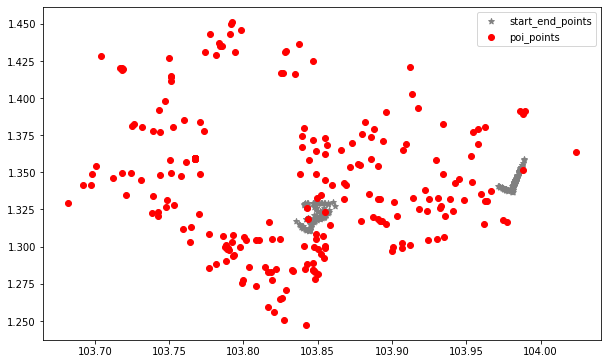

In [51]:
fig, ax = plt.subplots(figsize=(10,8))
top_3_startend.plot(ax=ax, color="grey", marker= "*", label="start_end_points")
poi_gdf.plot(ax=ax, color="Red", label="poi_points")

plt.legend()
plt.show() # we can see that our top 3 routes are near to a couple of our listed POIs

We then calculate the nearest POI for each of our pings!

In [52]:
def calculate_nearest(row, destination, val, col="geometry"):
    dest_unary = destination["geometry"].unary_union
    nearest_geom = nearest_points(row[col], dest_unary)
    match_geom = destination.loc[destination.geometry == nearest_geom[1]]
    match_value = match_geom[val].to_numpy()[0]
    return match_value

In [53]:
top_3_startend["nearest_geom"] = top_3_startend.apply(calculate_nearest, destination=poi_gdf, val="geometry", axis=1)
top_3_startend["nearest_name"] = top_3_startend.apply(calculate_nearest, destination=poi_gdf, val="name", axis=1)
top_3_startend['line'] = top_3_startend.apply(lambda row: LineString([row['geometry'], row['nearest_geom']]), axis=1)

/home/kenghwee/.cache/pypoetry/virtualenvs/grab-the-pulis-iQJvkJsy-py3.8/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/kenghwee/.cache/pypoetry/virtualenvs/grab-the-pulis-iQJvkJsy-py3.8/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/kenghwee/.cache/pypoetry/virtualenvs/grab-the-pulis-iQJvkJsy-py3.8/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [54]:
line_gdf = top_3_startend[["trj_id", "nearest_name", "line"]].set_geometry("line")
line_gdf.crs =  "epsg:4326"

We can now visualize the nearest POIs along with the pings!

In [55]:
center = [1.287953,103.851784] # lat, lng of central Singapore
zoom = 13

m = folium.Map(center=center,
               zoom_start = 2)
loc_trips = zip(top_3_startend.geometry.y, top_3_startend.geometry.x)
loc_poi = zip(poi_gdf.geometry.y, poi_gdf.geometry.x)
for location in loc_trips:
    folium.CircleMarker(location=location, color="white", radius=8).add_to(m)
for location in loc_poi:
    folium.CircleMarker(location=location, color="red", radius=4).add_to(m)
folium.GeoJson(line_gdf).add_to(m)
m

In [56]:
# Calculate distance between the POIs and the pings!
def convert_crs(element):
    element.crs = 'EPSG:3857' # convert to meter system
    return element.length

top_3_startend["length"] = top_3_startend["line"].apply(convert_crs)

/tmp/ipykernel_63862/3580662626.py:3: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  element.crs = 'EPSG:3857' # convert to meter system
/home/kenghwee/.cache/pypoetry/virtualenvs/grab-the-pulis-iQJvkJsy-py3.8/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [57]:
top_3_startend["nearest_name"].value_counts() # we can see that most of our top 3 routes indeed are nearby to Changi Airport

Changi Airport                          99
Whampoa Spring                          49
Goldhill Centre                         40
Changi Business Park                    39
Balestier Hill Shopping Centre          18
Toa Payoh Central                       15
Land Transport Authority (Hampshire)    15
Potong Pasir Neighbourhood Centre        1
Name: nearest_name, dtype: int64

In [58]:
changi_ids = top_3_startend.loc[top_3_startend["nearest_name"] == "Changi Airport", "trj_id"].values # we collect the IDs related to changi
changi_df = sg_df.loc[sg_df["trj_id"].isin(changi_ids)] # this contains the entire route data for trips starting or ending with changi

#### For all the Changi routes, we are interested to find out the speed graph of trajectories.
A speed graph is essentially a plot of the speeds at different time-points of the ride. Note that each trip has different durations, so to do this visualization, we have to **normalize the x-axis into a percentage of the ride.**

In [59]:
%%time
changi_df.sort_values(by=["trj_id", "pingtimestamp"], inplace=True)
non_changi_df.sort_values(by=["trj_id", "pingtimestamp"], inplace=True)

CPU times: user 105 ms, sys: 42 µs, total: 105 ms
Wall time: 104 ms


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [60]:
speed_dict = {} 
grouped = changi_df.groupby("trj_id")
for name, group in tqdm(grouped):
    trj_lst = []
    if not group.empty:
        start, end = group.pingtimestamp.min(), group.pingtimestamp.max()
        total_secs = end - start
        for _, row in group.iterrows():
            trj_lst.append([(row["pingtimestamp"] - start)  * 100 / total_secs, row["speed"]])
        speed_dict[row["trj_id"]] = trj_lst
        
changi_speed = pd.DataFrame([item for sublist in [list(map(lambda x: [key] + x, val)) for key, val in speed_dict.items()] for item in sublist], columns=["trj_id", "trip_pct", "speed"])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28000/28000 [00:07<00:00, 3576.33it/s]


In [61]:
changi_speed["trip_pct"] = np.ceil(changi_speed["trip_pct"]).astype('int32')

### We now get a dataframe with the average speed for each normalized percentile of the trip for all the Changi trips.

In [62]:
changi_speed_df = changi_speed.groupby("trip_pct").agg({"speed": np.mean}) 
changi_speed_df["speed"] = changi_speed_df["speed"] * 3600 / 1000

### Now, we proceed with the same manipulations for non-Changi routes
Recall that we have previously computed `non_changi_df`, which involves routes not related to Changi.

In [63]:
speed_dict = {}
grouped = non_changi_df.groupby("trj_id")
for name, group in tqdm(grouped):
    trj_lst = []
    if not group.empty:
        start, end = group.pingtimestamp.min(), group.pingtimestamp.max()
        total_secs = end - start
        for _, row in group.iterrows():
            trj_lst.append([(row["pingtimestamp"] - start)  * 100 / total_secs, row["speed"]])
        speed_dict[row["trj_id"]] = trj_lst
        
            
        # final_indices.append(group.iloc[0].name)
        # final_indices.append(group.iloc[-1].name)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28000/28000 [00:07<00:00, 3957.53it/s]


In [64]:
non_changi_speed = pd.DataFrame([item for sublist in [list(map(lambda x: [key] + x, val)) for key, val in speed_dict.items()] for item in sublist], columns=["trj_id", "trip_pct", "speed"])

In [65]:
non_changi_speed["trip_pct"] = np.ceil(non_changi_speed["trip_pct"]).astype('int32')

In [66]:
non_changi_gdf = sg_gdf.loc[sg_gdf["trj_id"].isin(non_changi_ids)]

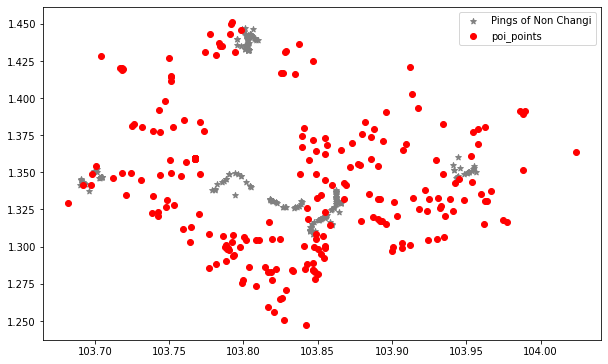

/home/kenghwee/.cache/pypoetry/virtualenvs/grab-the-pulis-iQJvkJsy-py3.8/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/kenghwee/.cache/pypoetry/virtualenvs/grab-the-pulis-iQJvkJsy-py3.8/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/kenghwee/.cache/pypoetry/virtualenvs/grab-the-pulis-iQJvkJsy-py3.8/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [67]:
fig, ax = plt.subplots(figsize=(10,8))
non_changi_gdf.plot(ax=ax, color="grey", marker= "*", label="Pings of Non Changi")
poi_gdf.plot(ax=ax, color="Red", label="poi_points")

plt.legend()
plt.show() # we can see that our top 3 routes are near to a couple of our listed POIs

non_changi_gdf["nearest_geom"] = non_changi_gdf.apply(calculate_nearest, destination=poi_gdf, val="geometry", axis=1)
non_changi_gdf["nearest_name"] = non_changi_gdf.apply(calculate_nearest, destination=poi_gdf, val="name", axis=1)
non_changi_gdf['line'] = non_changi_gdf.apply(lambda row: LineString([row['geometry'], row['nearest_geom']]), axis=1)

In [68]:
non_changi_line_gdf = non_changi_gdf[["trj_id", "nearest_name", "line"]].set_geometry("line")
non_changi_line_gdf.crs =  "epsg:4326"

In [69]:
center = [1.287953,103.851784] # lat, lng of central Singapore
zoom = 13

m = folium.Map(center=center,
               zoom_start = 2)
loc_trips = zip(non_changi_gdf.geometry.y, non_changi_gdf.geometry.x)
loc_poi = zip(poi_gdf.geometry.y, poi_gdf.geometry.x)
for location in loc_trips:
    folium.CircleMarker(location=location, color="white", radius=8).add_to(m)
for location in loc_poi:
    folium.CircleMarker(location=location, color="red", radius=4).add_to(m)
folium.GeoJson(non_changi_line_gdf).add_to(m)
m

In [70]:
non_changi_speed_df = non_changi_speed.groupby("trip_pct").agg({"speed": np.mean})
non_changi_speed_df["speed"] = non_changi_speed_df["speed"] * 3600 / 1000

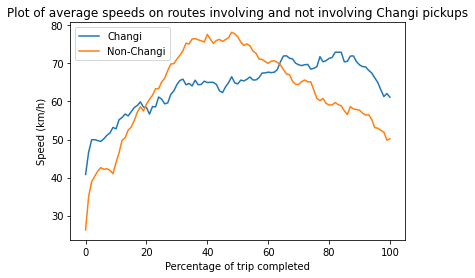

In [72]:
fig, ax = plt.subplots()
ax.plot(changi_speed_df.index, changi_speed_df.speed, label="Changi")
ax.plot(non_changi_speed_df.index, non_changi_speed_df.speed, label="Non-Changi")
ax.legend()
ax.set_ylabel("Speed (km/h)")
ax.set_xlabel("Percentage of trip completed")
ax.set_title("Plot of average speeds on routes involving and not involving Changi pickups")
plt.show()

### Hypothesis:
* We see that at the start and the end of the trip, the non-Changi pickups are slower. Looking at the map visualizations earlier, the delay could be attributed to single-line, narrow shopping mall pick-up and drop-off points. We can clearly see that for the initial 5% of the trip, the speed is less than 30km/hour.

* Drivers do not have a choice, but to wait in the single-lane queue for pickup and dropoffs for retail shopping malls. We compare this to Changi Airport, where pickup and dropoff can be very fast due to the extensive road-infrastructure, which was optimised for quick pickups and drop-offs for less user friction felt by tourists.

### Proposed Solution:
We were largely inspired by the talks with our peers and family, where one of them whom was a Grab driver actually told us about the idea of "heatmaps" available in the driver's UI. The first thought that came to our minds, was "Hey, why can't we have that for the users?"

<p> To be more specific, we believe having such a crowd heat-map could possibly be a win-win solution for both Grab riders and drivers! </p>

<u>Benefits include:</u>
* A **win** for users: Grab could possibly recommend alternative pick-up or drop-off points, which are relatively less crowded, albeit, near enough for walking. Case in point could be the different malls in Orchard. This allows users to possibly avoid a less-expensive surge pricing and also saves waiting time for the driver to reach the front of the queue.

* A **win** for drivers: Interestingly, some of the Grab driver friends and family we have talked to, would much rather prefer to not wait in a pick-up or drop-off queue and pickup a new passenger. This can be understood by the incentives currently offered by Grab for completing a certain number of trips, and drivers seek for most cost-effictive trips to take! Understandably, some drivers would rather wait in a queue, in a bid to obtain a better surge pricing. We believe that this can vary between individuals, but having this crowd-map for users would definitely help the cost-effective seeking drivers to get a sizable demand in the previously less-popular malls and areas.

* A **win** for COVID-struck Singapore: Less crowds as we have people who are able and willing to walk to less-crowded places to save money and time, ultimately not having too much crowds at only a select few locations. 

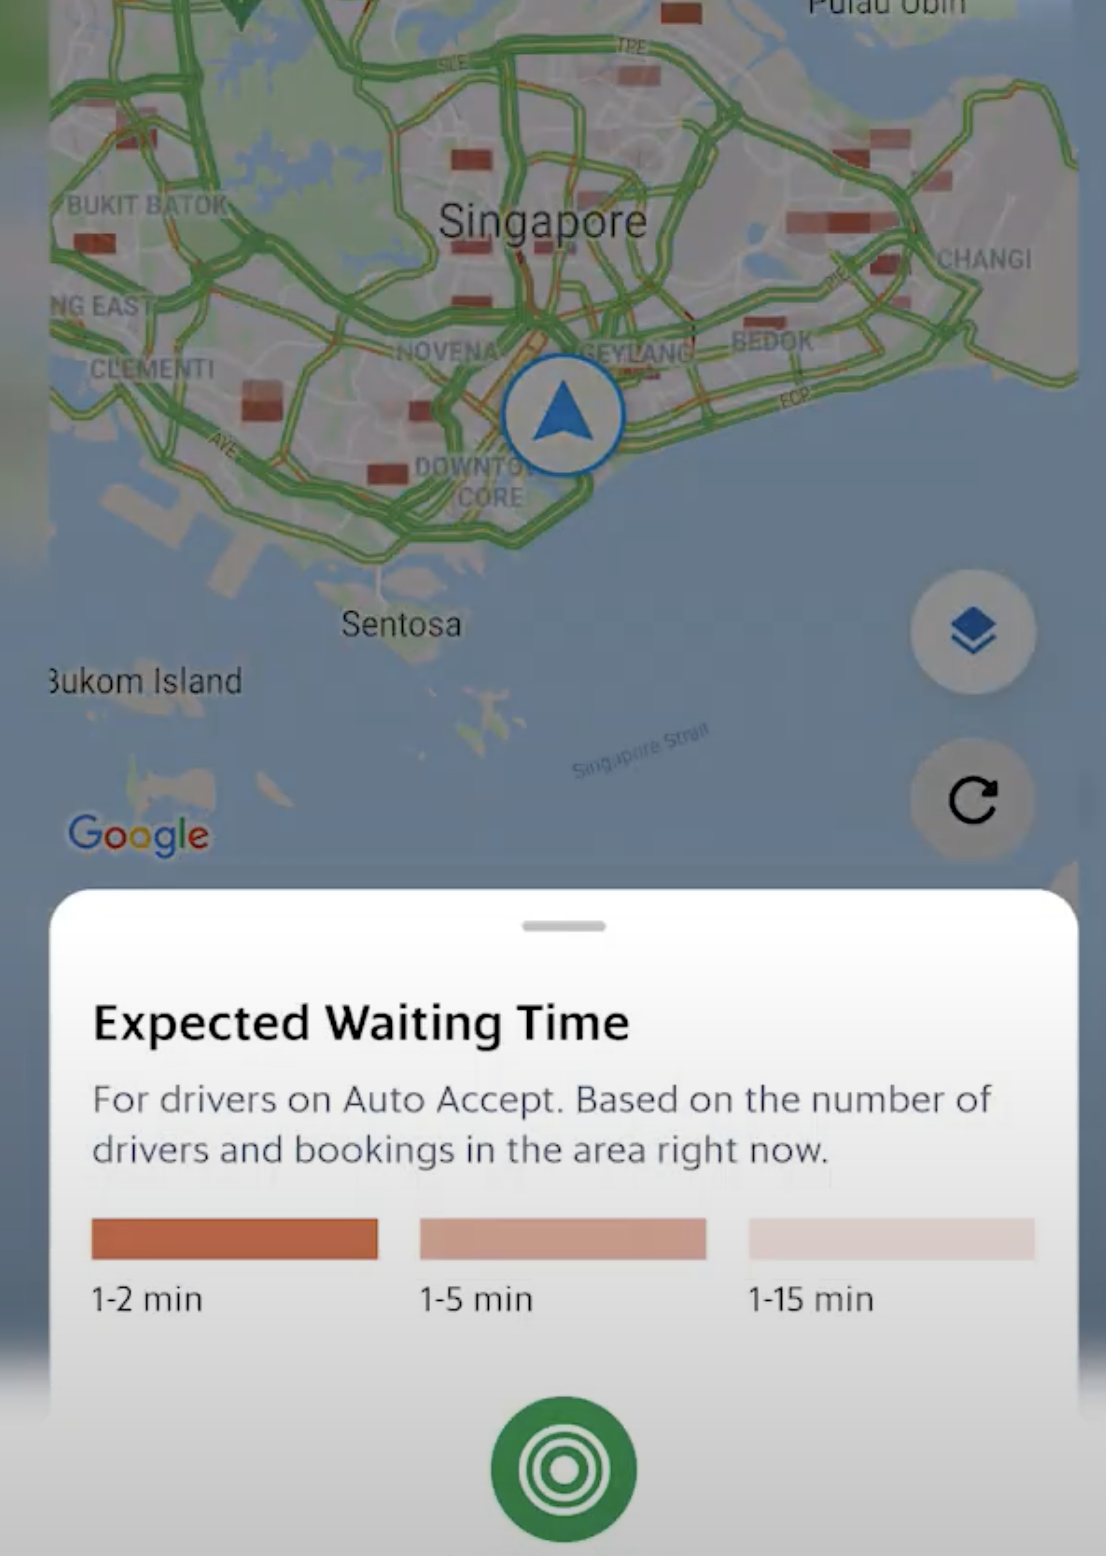
